SKIN CANCER DECTECTION WITH TENSORFLOW

In [1]:
import seaborn as sns
print(sns.__version__)


0.13.2


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns


import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')


let's check the number of images we have got here

In [3]:
images = glob('train_cancer/*/*.jpg')
len(images)


270

In [4]:
#replace backslash with forward slash to avoid unexpected errors
images = [path.replace('\\', '/') for path in images]
df = pd.DataFrame({'filepath': images})
df['label'] = df['filepath'].str.split('/', expand=True)[1]
df.head()


,filepath,label
0,train_cancer/benign/12.jpg,benign
1,train_cancer/benign/13.jpg,benign
2,train_cancer/benign/14.jpg,benign
3,train_cancer/benign/17.jpg,benign
4,train_cancer/benign/19.jpg,benign


In [5]:
#converting the labels to 0 and 1 will save our work of label encoding so, let's do this right now

df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)
df.head()


,filepath,label,label_bin
0,train_cancer/benign/12.jpg,benign,0
1,train_cancer/benign/13.jpg,benign,0
2,train_cancer/benign/14.jpg,benign,0
3,train_cancer/benign/17.jpg,benign,0
4,train_cancer/benign/19.jpg,benign,0


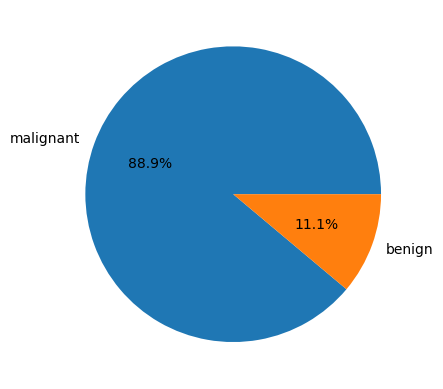

In [6]:
x = df['label'].value_counts()
plt.pie(x.values,
        labels=x.index,
        autopct='%1.1f%%')
plt.show()


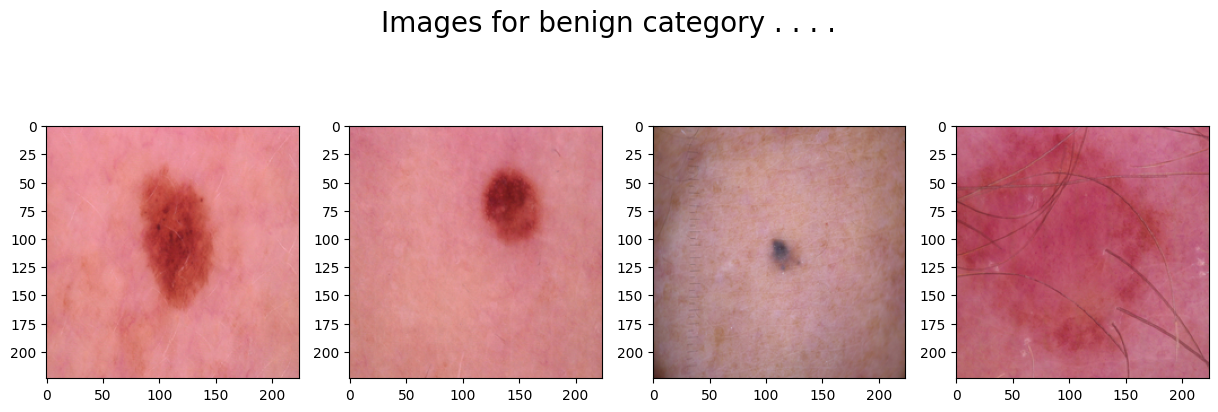

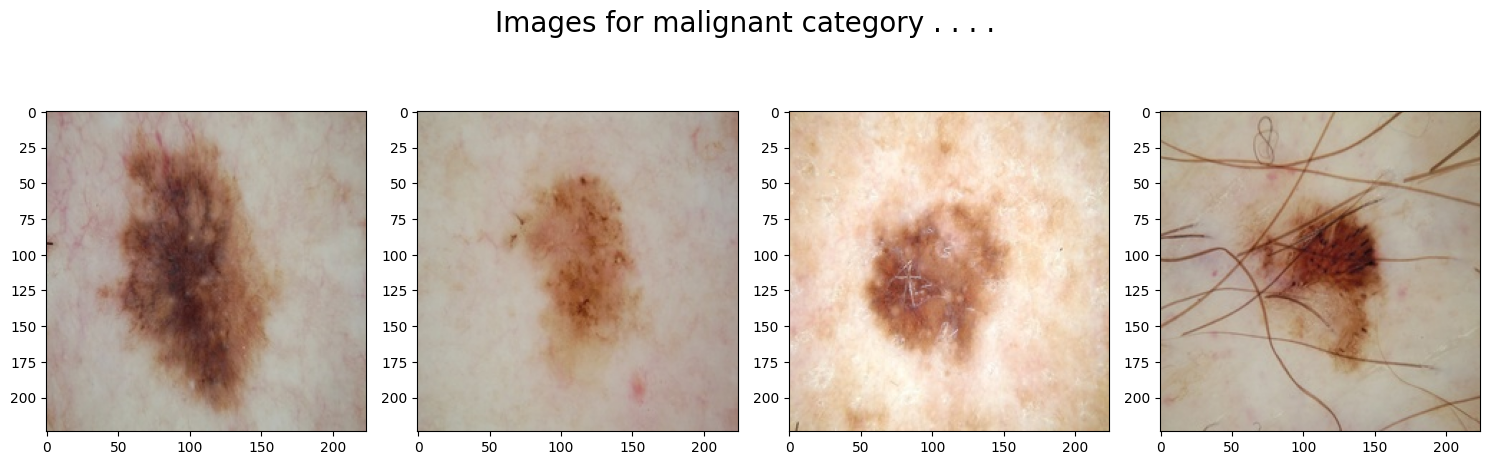

In [7]:
for cat in df['label'].unique():
    temp = df[df['label'] == cat]

    index_list = temp.index
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(4):
        index = np.random.randint(0, len(index_list))
        index = index_list[index]
        data = df.iloc[index]

        image_path = data[0]

        img = np.array(Image.open(image_path))
        ax[i].imshow(img)
plt.tight_layout()
plt.show()


let's split the data into training and validation parts by using the train_test_split function

In [8]:
features = df['filepath']
target = df['label_bin']

X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.15,
                                      random_state=10)

X_train.shape, X_val.shape


((229,), (41,))

In [9]:
def decode_image(filepath, label=None):

    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0

    # Compare label with integer 0 or 1 instead of string
    if label == 0: 
        Label = 0
    else:
        Label = 1

    return img, Label

Image input pipelines have been implemented below so, that we can pass them without any need to load all the data beforehand.

In [10]:
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)


MODEL DEVELOPMENT

using The EfficientNet architecture and leverage the benefit of pre-trained weights of such large networks


MODEL ARCHITECTURE

using the Functional API of keras which will contain the following parts:
.The base model is the EfficientNet model in this case
.The Flatten layer flattens the output of the base model's output
.Then we will have 2 fully connected layers followed by the output of the flattened layer
.we have included some BatchNormalization layers to enable stable and fast training and a Dropout layer before the final layer to avoid any possibility of overfitting
.The final layer is the output layer which outputs soft prbailities for the three classes

In [11]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

pre_trained_model = EfficientNetB7(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

for layer in pre_trained_model.layers:
    layer.trainable = False


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Pour binaire
])


In [13]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['AUC']
)


In [14]:
for img, lbl in train_ds.take(1):
    print(f"Image batch shape: {img.shape}")


Image batch shape: (32, 224, 224, 3)


In [15]:
#let's train our model
history = model.fit(train_ds, 
                    validation_data = val_ds,
                    epochs = 5,
                    verbose = 1)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - AUC: 0.5004 - loss: 9.9520 - val_AUC: 0.5000 - val_loss: 12.0110
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 769ms/step - AUC: 0.5461 - loss: 5.6643 - val_AUC: 0.5000 - val_loss: 2.9738
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 660ms/step - AUC: 0.5832 - loss: 1.9120 - val_AUC: 0.3682 - val_loss: 0.4469
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 639ms/step - AUC: 0.6663 - loss: 0.4012 - val_AUC: 0.9865 - val_loss: 0.1418
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 663ms/step - AUC: 0.8239 - loss: 0.3434 - val_AUC: 0.9865 - val_loss: 0.2032


In [16]:
#let's visualize the trianing and validation loss and AUC with each epoch
hist_df = pd.DataFrame(history.history)
hist_df.head()

,AUC,loss,val_AUC,val_loss
0,0.505968,12.012913,0.500000,12.010992
1,0.507958,4.670242,0.500000,2.973828
2,0.647120,1.198981,0.368243,0.446876
3,0.675919,0.352910,0.986486,0.141793
4,0.835354,0.301157,0.986486,0.203166


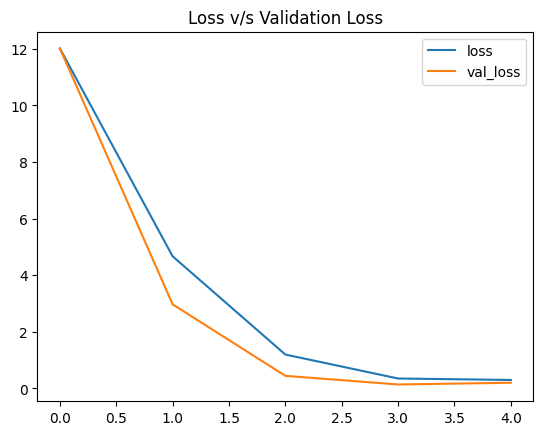

In [17]:
hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()


In [21]:
print(hist_df.columns)

Index(['AUC', 'loss', 'val_AUC', 'val_loss'], dtype='object')


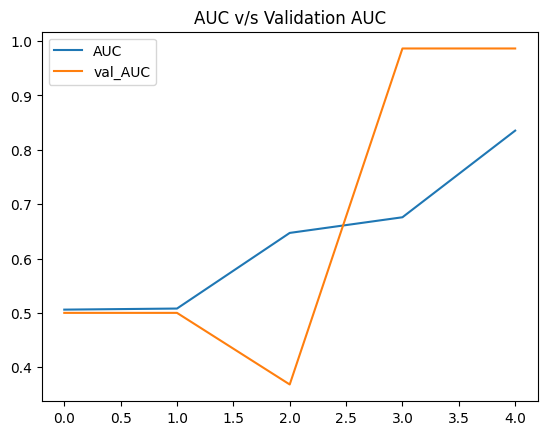

In [23]:
hist_df['AUC'].plot()
hist_df['val_AUC'].plot()
plt.title('AUC v/s Validation AUC')
plt.legend()
plt.show()
